In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate,BatchNormalization,GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.backend import clear_session



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-06-19 20:33:35.234064: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-19 20:33:36.041916: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-19 20:33:36.041977: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

### Loading the Full prepared dataset  cleaned data using nltk library- FakeNewsNet

In [2]:
#creating a data frame
df = pd.read_csv("Updated//full_dataset.csv")

In [3]:
df = df[df['fulltext'].notna()]

In [4]:
df.shape

(20362, 9)

In [5]:
df['fulltext'].isnull().sum()

0

In [6]:
## Shuffling the rows
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
# Clean data using the built in cleaner in gensim
df['cleantext'] = df['fulltext'].apply(lambda x: gensim.utils.simple_preprocess(x))
#df.head(1)

In [8]:
X=df['cleantext']
y=df['class']

### Train and Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

In [10]:
# now since we will have to pad we need to find the maximum lenght of any document.

maxi=-1
for i,sent in enumerate(df['cleantext']):
    if(len(sent)>maxi):
        maxi=len(sent)
print(maxi)

17351


In [11]:
print("Maximum Length of the sequence : ",maxi)

Maximum Length of the sequence :  17351


#### Now we integer encode the words in the reviews using Keras tokenizer.

In [12]:
tokenzr = Tokenizer()

In [ ]:
tokenzr.fit_on_texts(X_train)
vocab_size = len(tokenzr.word_index) + 1
encd_train = tokenzr.texts_to_sequences(X_train)

In [ ]:
encd_test = tokenzr.texts_to_sequences(X_test)

##### Configuration Setting

In [ ]:
print(len(tokenzr.word_index))

In [ ]:
maxi=10000  # max lenght of a review
vocab_size = len(tokenzr.word_index) + 1  # total no of words
embed_dim=300 # embedding dimension as choosen in word2vec constructor

In [ ]:
# now padding to have a maximum length of 17351
pad_train= pad_sequences(encd_train, maxlen=maxi, padding='post')
pad_train.shape   

In [ ]:
# now padding to have a maximum length of 1565
pad_test= pad_sequences(encd_test, maxlen=maxi, padding='post')
pad_test.shape

### Word2vec

##### Learning Embeddings from Scratch

In [24]:
# Train the word2vec model
w2v_embedng_model = gensim.models.Word2Vec(X_train,
                                   vector_size=300,
                                   window=5,
                                   min_count=2)

In [25]:
#print(type(w2v_embedng_model))

In [26]:
# total numberof extracted words.
vocab=w2v_embedng_model.wv.index_to_key
print("The total number of words are : ",len(vocab))

The total number of words are :  63307


In [27]:
#print(type(vocab))

In [28]:
#print(vocab)
#vocab=list(vocab)

#### Finding out the vocabulary count

In [29]:
word_vec_dict={}
for word in vocab:
    word_vec_dict[word]=w2v_embedng_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) # should come equal to vocab size
  

The no of key-value pairs :  63307


#### Creation of Embedding matrix

Create an embedding matrix by assigning the vocabulary with the pretrained word embeddings:

In [30]:
# now creating the embedding matrix
embedded_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tokenzr.word_index.items():
    embedded_vec=word_vec_dict.get(word)
    if embedded_vec is not None:  # word is in the vocabulary learned by the w2v model
        embedded_matrix[i]=embedded_vec # if word is not found then embed_vector corressponding to that vector will stay zero.

### LSTM

In [43]:
# Model Checkpoint and EarlyStopping
filepath = "Updated//modelFakeNewsNetLSTM_WORD2VEC.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [46]:
from keras.initializers import Constant
lstm_model=Sequential()
lstm_model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedded_matrix)))
lstm_model.add(LSTM(64,return_sequences=False)) # loss stucks at about 
lstm_model.add(Flatten())
lstm_model.add(Dense(16,activation='relu'))
lstm_model.add(Dropout(0.50))
# model.add(Dense(16,activation='relu'))
# model.add(Dropout(0.20))
lstm_model.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
lstm_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-3),loss='binary_crossentropy',metrics=['accuracy'])

In [47]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10000, 300)        29481000  
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 29,575,497
Trainable params: 29,575,497


In [ ]:
history_lstm_word2vec=lstm_model.fit(pad_train,y_train,epochs=3,batch_size=32,validation_split=0.2,shuffle=True, callbacks=callbacks_list)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
408/408 [==============================] - ETA: 0s - loss: 0.5868 - accuracy: 0.7517 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2afede6c6b70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

In [46]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(history):
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]

    fig = plt.figure(figsize=(12,5))

    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");

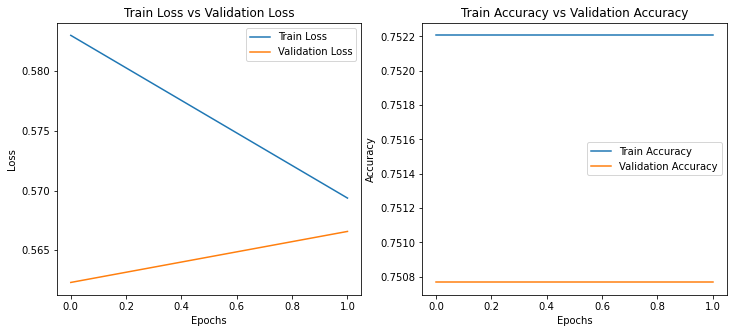

In [47]:
plot_loss_and_acc(history_lstm_word2vec)

## Pretrained Word2vec model

In [ ]:
# !wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [31]:
path_to_model = 'Embeddings//GoogleNews-vectors-negative300.bin'

In [32]:
from gensim.models.keyedvectors import KeyedVectors
%time w2v_model_pretrained = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
print('done loading Word2Vec')

CPU times: user 22.6 s, sys: 3.08 s, total: 25.7 s
Wall time: 27 s
done loading Word2Vec


In [33]:
#Inspect the model
#word2vec_vocab = list(w2v_model.index_to_key)

In [34]:
# total numberof extracted words.
word2vec_vocab=w2v_model_pretrained.index_to_key
print("The total number of words are : ",len(word2vec_vocab))

The total number of words are :  3000000


In [35]:
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]

#### Finding out the vocabulary count

In [36]:
word_vec_dict_pre={}
for word in word2vec_vocab:
    word_vec_dict_pre[word]=w2v_model_pretrained.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict_pre)) # should come equal to vocab size
  

The no of key-value pairs :  3000000


#### Creation of Embedding matrix

In [37]:
embed_dim

300

In [38]:
# now creating the embedding matrix
embedded_matrix_2=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tokenzr.word_index.items():
    embedded_vec=word_vec_dict_pre.get(word)
    if embedded_vec is not None:  # word is in the vocabulary learned by the w2v model
        embedded_matrix_2[i]=embedded_vec

In [39]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(history):
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]

    fig = plt.figure(figsize=(12,5))

    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");


### 1d CNN

In [40]:
# Model Checkpoint and EarlyStopping
filepath = "Updated//modelFakeNewsNet_CNN_WORD2VEC_PRETRAINED.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [42]:
warnings.filterwarnings('ignore')
cnn_model=Sequential()
cnn_model.add(Embedding(vocab_size,embed_dim,input_length=maxi))
cnn_model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1, activation='sigmoid'))
# compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 300)        29595000  
                                                                 
 conv1d (Conv1D)             (None, 9998, 128)         115328    
                                                                 
 conv1d_1 (Conv1D)           (None, 9996, 64)          24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4998, 64)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 4998, 32)          6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2499, 32)         0         
 1D)                                                  

In [43]:
history_cnn_word2vec=cnn_model.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
102/102 [==============================] - ETA: 0s - loss: 0.5220 - accuracy: 0.7498WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2aefe6e657b8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

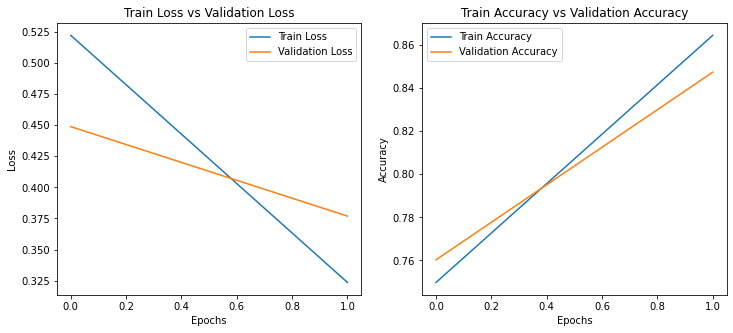

In [44]:
plot_loss_and_acc(history_cnn_word2vec)

### LSTM

In [59]:
# Model Checkpoint and EarlyStopping
filepath = "Updated//modelFakeNewsNetLSTM_WORD2VEC_PRETRAINED.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [61]:
from keras.initializers import Constant
lstm_model=Sequential()
lstm_model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedded_matrix_2),trainable=True))
lstm_model.add(LSTM(128,return_sequences=True,dropout=0.2)) # loss stucks at about 
lstm_model.add(GlobalMaxPooling1D())
lstm_model.add(Dense(64,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
lstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [62]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10000, 300)        29623500  
                                                                 
 lstm_1 (LSTM)               (None, 10000, 128)        219648    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 29,851,469
Trainable params: 29,851,469
Non-trainable params: 0
__________________________________________

In [63]:
history_lstm_word2vec=lstm_model.fit(pad_train,y_train,epochs=3,batch_size=200,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
66/66 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.7583 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2ab104adb488> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

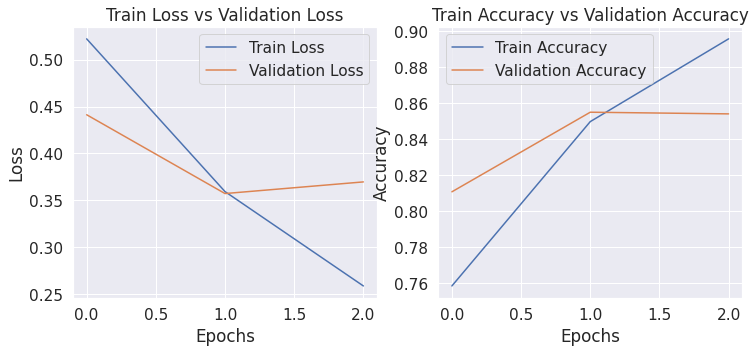

In [64]:
plot_loss_and_acc(history_lstm_word2vec)

### Bi LSTM

In [30]:
# Model Checkpoint and EarlyStopping
filepath = "Updated//modelFakeNewsNet_BiLSTM_WORD2VEC_PRETRAINED.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [31]:
from keras.initializers import Constant
bilstm_model=Sequential()
bilstm_model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedded_matrix_2),trainable=True))
bilstm_model.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))) # loss stucks at about 
bilstm_model.add(GlobalMaxPooling1D())
bilstm_model.add(Dense(64,activation='relu'))
bilstm_model.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
bilstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [32]:
bilstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 300)        29293800  
                                                                 
 bidirectional (Bidirectiona  (None, 10000, 256)       439296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 29,749,609
Trainable params: 29,749,609


In [33]:
history_bilstm_word2vec=bilstm_model.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
102/102 [==============================] - ETA: 0s - loss: 0.4777 - accuracy: 0.7858 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b7643825ea0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

In [29]:
# from keras.models import load_model
# bilstm_model = load_model('Updated//modelFakeNewsNet_BiLSTM_WORD2VEC_PRETRAINED.h5')

## Glove

##### using PreTrained

##### Download the pretrained zip file

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

##### Unzip it

In [ ]:
# !unzip glove*.zip

In [ ]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [ ]:
glove_path = 'Embeddings//glove.6B.300d.txt'

In [ ]:
import os
glove_embeddings_index = {}
f = open(os.path.join(glove_path), encoding="utf8")

In [ ]:
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings_index[word] = coefs
f.close()

In [ ]:
print('Total %s word vectors in Glove.' % len(glove_embeddings_index))


In [ ]:
embedding_gmatrix = np.random.random((len(tokenzr.word_index) + 1, embed_dim))
for word, i in tokenzr.word_index.items():
    embedding_gvector = glove_embeddings_index.get(word)
    if embedding_gvector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_gmatrix[i] = embedding_gvector

### 1D CNN

In [53]:
# Model Checkpoint and EarlyStopping
filepath = "Updated//modelFakeNewsNet_CNN_GLOVE.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [54]:
warnings.filterwarnings('ignore')
cnn_model_g=Sequential()
cnn_model_g.add(Embedding(vocab_size,embed_dim,input_length=maxi))
cnn_model_g.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
cnn_model_g.add(Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu'))
cnn_model_g.add(MaxPooling1D())
cnn_model_g.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_model_g.add(MaxPooling1D())
cnn_model_g.add(Flatten())
cnn_model_g.add(Dense(128, activation='relu'))
cnn_model_g.add(Dropout(0.4))
cnn_model_g.add(Dense(64, activation='relu'))
cnn_model_g.add(Dropout(0.2))
cnn_model_g.add(Dense(1, activation='sigmoid'))
# compile the model
cnn_model_g.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(cnn_model_g.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 300)        29595000  
                                                                 
 conv1d (Conv1D)             (None, 9998, 128)         115328    
                                                                 
 conv1d_1 (Conv1D)           (None, 9996, 64)          24640     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4998, 64)         0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 4998, 32)          6176      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2499, 32)         0         
 1D)                                                    

In [55]:
history_cnn_glove=cnn_model_g.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
102/102 [==============================] - ETA: 0s - loss: 0.5317 - accuracy: 0.7509WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2af2a6fb89d8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

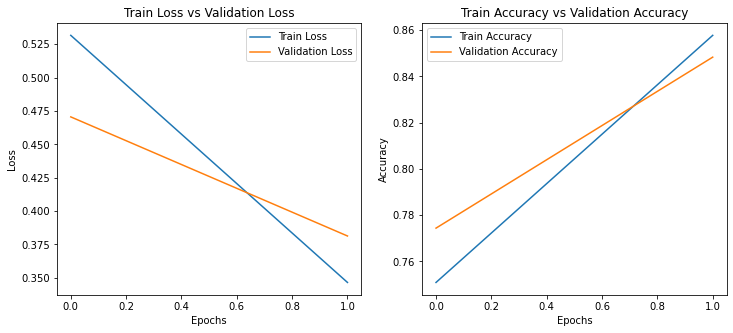

In [56]:
plot_loss_and_acc(history_cnn_glove)

### LSTM

In [51]:
clear_session()

In [35]:
# Model Checkpoint and EarlyStopping
filepath = "Updated//modelFakeNewsNetLSTM_GLOVE.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [36]:
from keras.initializers import Constant
lstm_model_g=Sequential()
lstm_model_g.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedding_gmatrix),trainable=True))
lstm_model_g.add(LSTM(128,return_sequences=True,dropout=0.2)) # loss stucks at about 
lstm_model_g.add(GlobalMaxPooling1D())
lstm_model_g.add(Dense(64,activation='relu'))
lstm_model_g.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
lstm_model_g.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [31]:
clear_session()

In [32]:
lstm_model_g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 300)        29623500  
                                                                 
 lstm (LSTM)                 (None, 10000, 128)        219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 29,851,469
Trainable params: 29,851,469
Non-trainable params: 0
____________________________________________

In [33]:
history_lstm_glove=lstm_model_g.fit(pad_train,y_train,epochs=3,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
102/102 [==============================] - ETA: 0s - loss: 0.4916 - accuracy: 0.7785 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2aafe3eea1e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

### Bi-LSTM

In [ ]:
# Model Checkpoint and EarlyStopping
filepath = "Updated//modelFakeNewsNet_BiLSTM_GLOVE.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [ ]:
from keras.initializers import Constant
bilstm_model_g=Sequential()
bilstm_model_g.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedding_gmatrix),trainable=True))
bilstm_model_g.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))) # loss stucks at about 
bilstm_model_g.add(GlobalMaxPooling1D())
bilstm_model_g.add(Dense(64,activation='relu'))
bilstm_model_g.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
bilstm_model_g.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
clear_session()

In [ ]:
bilstm_model_g.summary()

In [ ]:
history_bilstm_glove=bilstm_model_g.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

In [ ]:
history_bilstm_glove=bilstm_model_g.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
102/102 [==============================] - ETA: 0s - loss: 0.4914 - accuracy: 0.7781 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b0393e95f28> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

In [4]:
# from keras.models import load_model
# bilstm_model = load_model('Updated//modelFakeNewsNet_BiLSTM_GLOVE.h5')

In [ ]:
plot_loss_and_acc(history_bilstm_glove)